**Library imports**

In [1]:
import tensorflow as tf
import keras
from keras import layers
from keras import Sequential 
from keras.layers import Dense, Flatten
import os

Using TensorFlow backend.


**TensorBoard**

In [0]:
LOG_DIR = '/tmp/log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)


In [0]:
#!rm -Rf /tmp/log/*
#!fuser 6006/tcp -k

In [38]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip -o ngrok-stable-linux-amd64.zip


--2019-02-06 14:21:25--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 54.152.127.232, 52.72.245.79, 52.72.145.109, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.152.127.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.2’

ngrok-stable-linux- 100%[===================>]   5.11M  9.44MB/s    in 0.5s    

2019-02-06 14:21:26 (9.44 MB/s) - ‘ngrok-stable-linux-amd64.zip.2’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [40]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"


http://cb833704.ngrok.io


In [0]:
# easy code to clean TensorBoard (not the best but useful)
import shutil

shutil.rmtree('/tmp/log', ignore_errors=True)

**DataFlow Programming Language**

In [7]:
node1 = tf.constant(5.0, dtype=tf.float32)
node2 = tf.constant(10.0, dtype=tf.float32)
node3 = tf.add(node1,node2)


sess = tf.Session()
file_writer = tf.summary.FileWriter('/tmp/log', sess.graph)
print (sess.run(node3))
sess.close()


15.0


In [0]:
x = 2
y = 3
op1 = tf.add(x, y)
op2 = tf.multiply(x, y)
op3 = tf.pow(op2, op1)
with tf.Session() as sess:
  file_writer = tf.summary.FileWriter('/tmp/log', sess.graph)
  op3 = sess.run(op3)

In [9]:
op4 = tf.multiply(op1, op2)
op5 = tf.pow(op1, op4)
with tf.Session() as sess:
  file_writer = tf.summary.FileWriter('/tmp/log', sess.graph)
  z = sess.run(op5)
  print(z)

433305513


**MNIST**

In [0]:
#
# https://stackoverflow.com/questions/47877475/keras-tensorboard-plot-train-and-validation-scalars-in-a-same-figure/48393723
#
class TrainValTensorBoard(keras.callbacks.TensorBoard):
    def __init__(self, log_dir='./logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()

**Dataset**

In [29]:
from keras.datasets import mnist

# split train and validation
(x_train, y_train), (x_valid, y_valid) = mnist.load_data()

print('X train shape: {}'.format(x_train.shape))
print('X valid shape: {}'.format(x_valid.shape))
print('Y train shape: {}'.format(y_train.shape))
print('Y train shape: {}'.format(y_valid.shape))

X train shape: (60000, 28, 28)
X valid shape: (10000, 28, 28)
Y train shape: (60000,)
Y train shape: (10000,)


In [0]:
# Normalize of pixel between 1 and 0
CLASSES = 10

y_train_r = keras.utils.to_categorical(y_train, CLASSES)
y_valid_r = keras.utils.to_categorical(y_valid, CLASSES)

x_train_r = x_train / 255
x_valid_r  = x_valid / 255

Real label: 8


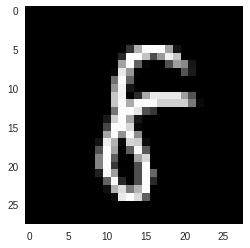

In [31]:
import matplotlib.pyplot as plt

SAMPLE = 456

plt.figure(figsize = (4, 4))
plt.imshow(x_train[SAMPLE, :], cmap='gray')
plt.grid(False)

print("Real label:", y_train[SAMPLE])

**Models definition**

In [0]:
EPOCHS = 40
BATCH_SIZE = 256

**Softmax classification**

In [33]:
from keras import Sequential
from keras.layers import Dense, Flatten

model = Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(units = 10, activation="softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train_r, y_train_r, validation_data=(x_valid_r, y_valid_r),
          epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0,
          callbacks=[TrainValTensorBoard(log_dir='/tmp/log/softmax')])

**MLP**

In [44]:
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))

model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))

model.add(Dense(units = 10, activation="softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                510       
Total params: 84,060
Trainable params: 84,060
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train_r, y_train_r, validation_data=(x_valid_r, y_valid_r),
          epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0,
          callbacks=[TrainValTensorBoard(log_dir='/tmp/log/MLP')])

**MLP + Dropout**

In [46]:
from keras.layers import Dropout

model = Sequential()
model.add(Flatten(input_shape=(28, 28)))

model.add(Dense(100, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(50, activation='relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(units = 10, activation="softmax"))

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               78500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                510       
Total params: 84,060
Traina

In [47]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train_r, y_train_r, validation_data=(x_valid_r, y_valid_r),
          epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0,
          callbacks=[TrainValTensorBoard(log_dir='/tmp/log/MLP + Dropout')])

**CNN**

In [49]:
from keras import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(64, (5, 5), input_shape=(28, 28, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Flatten())
model.add(Dense(units = 10, activation="softmax"))

model.summary()
x_train_r = x_train_r.reshape(x_train_r.shape[0], 28, 28, 1)
x_valid_r = x_valid_r.reshape(x_valid_r.shape[0], 28, 28, 1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 32)          51232     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                330       
Total params: 53,226
Trainable params: 53,226
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train_r, y_train_r, validation_data=(x_valid_r, y_valid_r),
          epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0,
          callbacks=[TrainValTensorBoard(log_dir='/tmp/log/CNN')])

**CNN+Dropout**

In [51]:
from keras import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

model = Sequential()
model.add(Conv2D(64, (5, 5), input_shape=(28, 28, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(32, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(rate=0.25))

model.add(Flatten())
model.add(Dense(units = 10, activation="softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 32)          51232     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 32)                0         
__________

In [52]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(x_train_r, y_train_r, validation_data=(x_valid_r, y_valid_r),
          epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0,
          callbacks=[TrainValTensorBoard(log_dir='/tmp/log/CNN+Dropout')])